## POS tagging using modified Viterbi

### Objective of the Assignment 

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in   the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate     functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the     original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk , re ,pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
random.seed(1234)

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [3]:
##splitting the data into the requested 95:5 ratio for training and validation
random.seed(1234)
train_set , val_set = train_test_split(nltk_data,test_size = 0.05)

In [4]:
print("-" * 100)
print("Training Set Length - " , len(train_set))
print("Validation Set Length - " , len(val_set))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Training Set Length -  3718
Validation Set Length -  196
----------------------------------------------------------------------------------------------------


In [5]:
##Lets have a look at samples from Training data set created
print(train_set[:10])

[[('FOREIGN', 'NOUN'), ('PRIME', 'NOUN'), ('RATES', 'NOUN'), (':', '.'), ('Canada', 'NOUN'), ('13.50', 'NUM'), ('%', 'NOUN'), (';', '.'), ('Germany', 'NOUN'), ('9', 'NUM'), ('%', 'NOUN'), (';', '.'), ('Japan', 'NOUN'), ('4.875', 'NUM'), ('%', 'NOUN'), (';', '.'), ('Switzerland', 'NOUN'), ('8.50', 'NUM'), ('%', 'NOUN'), (';', '.'), ('Britain', 'NOUN'), ('15', 'NUM'), ('%', 'NOUN'), ('.', '.')], [('Williams', 'NOUN'), ('shares', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-2', 'X'), ('were', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('delisted', 'VERB'), ('*-1', 'X'), ('from', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('after', 'ADP'), ('the', 'DET'), ('close', 'NOUN'), ('of', 'ADP'), ('composite', 'ADJ'), ('trading', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('closed', 'VERB'), ('at', 'ADP'), ('$', '.'), ('23.25', 'NUM'), ('*U*', 'X'), (',', '.'), ('off', 'ADV'), ('12.5', 'NUM'), ('cents', 'NOUN'), ('.', '.')], [('I

In [6]:
# Getting list of train tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]

print("-" * 100)
print("Train tagged words Length - " , len(train_tagged_words))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Train tagged words Length -  95711
----------------------------------------------------------------------------------------------------


In [7]:
##lets get the tags and tokens from tagged trained words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tags = [pair[1] for pair in train_tagged_words]

print("-" * 100)
print("Train data tokens length - " , len(train_data_tokens))
print("Train data tags distinct count - " , len(set(train_data_tags)))
print("\n")
print("Distinct Tags as per the universal tagset are as below -")
print(list(set(train_data_tags)))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Train data tokens length -  95711
Train data tags distinct count -  12


Distinct Tags as per the universal tagset are as below -
['PRT', 'ADP', 'NUM', 'ADJ', 'CONJ', 'ADV', '.', 'X', 'PRON', 'DET', 'NOUN', 'VERB']
----------------------------------------------------------------------------------------------------


As you can see from the count of distinct tags since we are using NLTK's universal tag set there are only 12 coarse tag classes as compared to 46 fine classes , this will make the Viterbi algorithm faster as well

In [8]:
##building the set of training vocabulary and POS tags

train_data_vocab_set = set(train_data_tokens)
train_data_tag_set   = set(train_data_tags)

print("-" * 100)
print("Train data vocabulary length - " , len(train_data_vocab_set))
print("Train data tag length - " ,len(train_data_tag_set))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Train data vocabulary length -  12081
Train data tag length -  12
----------------------------------------------------------------------------------------------------


## Emission and Transition Probabilities

In [9]:
# computing P(w/t) and storing in T x V matrix
t = len(train_data_tag_set)
v = len(train_data_vocab_set)
w_given_t = np.zeros((t, v))

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    taglist = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(taglist)
    w_given_tag_list = [pair[0] for pair in taglist if pair[0]== word]
    count_w_given_tag = len(w_given_tag_list)
    return(count_w_given_tag, tag_count)

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2,t1,train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    t1_tags = [tag for tag in tags if tag==t1]
    count_of_t1 = len(t1_tags)
    t2_given_t1 = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    count_t2_given_t1 = len(t2_given_t1)
    return(count_t2_given_t1,count_of_t1)


In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(train_data_tag_set), len(train_data_tag_set)), dtype='float32')

for i, t1 in enumerate(list(train_data_tag_set)):
    for j, t2 in enumerate(list(train_data_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix        

array([[1.96142541e-03, 2.02680621e-02, 5.78620471e-02, 8.56489018e-02,
        2.28832942e-03, 1.04609346e-02, 4.38051634e-02, 1.37299774e-02,
        1.69990193e-02, 1.00032687e-01, 2.47793391e-01, 3.99150044e-01],
       [1.38371473e-03, 1.71367750e-02, 6.32251203e-02, 1.06865354e-01,
        7.45077152e-04, 1.35178287e-02, 4.03406061e-02, 3.45928669e-02,
        6.82277828e-02, 3.23895693e-01, 3.21660459e-01, 8.40872806e-03],
       [2.71306392e-02, 3.50928940e-02, 1.85196102e-01, 3.30286063e-02,
        1.35653196e-02, 2.94898264e-03, 1.17074609e-01, 2.11442053e-01,
        1.17959303e-03, 3.53877922e-03, 3.53288114e-01, 1.65143032e-02],
       [1.11311181e-02, 7.82452151e-02, 2.04616133e-02, 6.74414784e-02,
        1.60419047e-02, 4.25601564e-03, 6.43313155e-02, 2.07889993e-02,
        6.54771633e-04, 4.58340161e-03, 6.99787199e-01, 1.22769680e-02],
       [5.14499517e-03, 5.42563125e-02, 4.02245075e-02, 1.21141255e-01,
        4.67726844e-04, 5.23854084e-02, 3.60149667e-02, 8.88

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_data_tag_set), index=list(train_data_tag_set))

In [14]:
tags_df

,PRT,ADP,NUM,ADJ,CONJ,ADV,.,X,PRON,DET,NOUN,VERB
PRT,0.001961,0.020268,0.057862,0.085649,0.002288,0.010461,0.043805,0.013730,0.016999,0.100033,0.247793,0.399150
ADP,0.001384,0.017137,0.063225,0.106865,0.000745,0.013518,0.040341,0.034593,0.068228,0.323896,0.321660,0.008409
NUM,0.027131,0.035093,0.185196,0.033029,0.013565,0.002949,0.117075,0.211442,0.001180,0.003539,0.353288,0.016514
ADJ,0.011131,0.078245,0.020462,0.067441,0.016042,0.004256,0.064331,0.020789,0.000655,0.004583,0.699787,0.012277
CONJ,0.005145,0.054256,0.040225,0.121141,0.000468,0.052385,0.036015,0.008887,0.059401,0.118335,0.349392,0.154350
ADV,0.014955,0.117647,0.031572,0.129279,0.006979,0.077434,0.137920,0.023928,0.014955,0.069458,0.030243,0.345630
.,0.002327,0.090128,0.081536,0.044751,0.056654,0.053074,0.095051,0.027119,0.064889,0.173812,0.221069,0.089501
X,0.184374,0.145710,0.002876,0.016616,0.010705,0.025723,0.162646,0.073973,0.054961,0.054801,0.063109,0.204506
PRON,0.012422,0.022516,0.007376,0.073370,0.004658,0.033385,0.041149,0.090062,0.007376,0.008929,0.210404,0.488354
DET,0.000242,0.009429,0.022244,0.205392,0.000363,0.012935,0.017650,0.045575,0.003506,0.005561,0.638298,0.038806


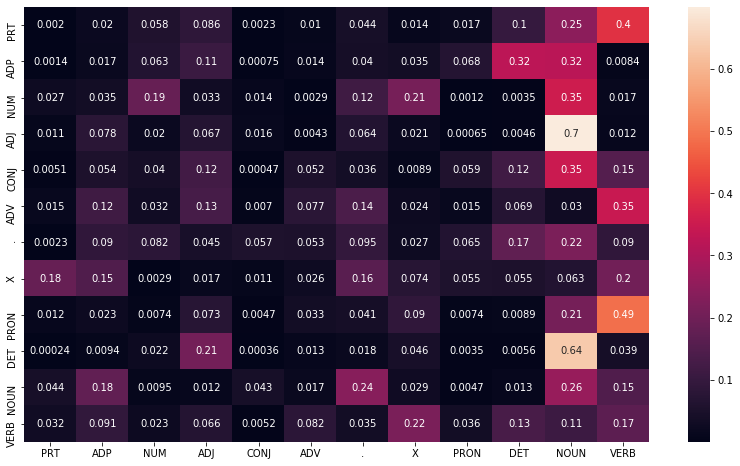

In [15]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

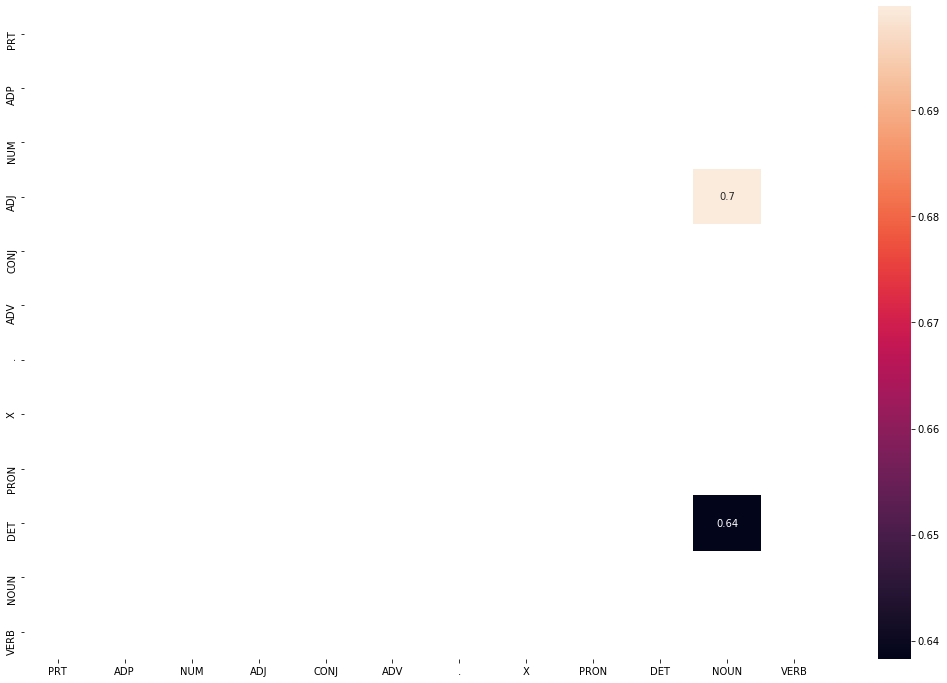

In [16]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent , annot = True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [17]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # lets compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Testing Vanilla Viterbi Algorithm on validation dataset

In [18]:
random.seed(1234)

##choose random 20 sents

##rndom = [random.randint(1,len(val_set)) for x in range(20)]

##list of sents
##val_run = [val_set[i] for i in rndom]

# list of tagged words
val_run_base = [tup for sent in val_set for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_set for tup in sent]
val_tagged_words

['Yesterday',
 ',',
 'Carnival',
 'said',
 '0',
 'a',
 'new',
 'company',
 '*ICH*-1',
 'has',
 'been',
 'formed',
 '*-2',
 'in',
 'Finland',
 'that',
 '*T*-3',
 'will',
 'carry',
 'on',
 'Waertsilae',
 "'s",
 'shipbuilding',
 'operations',
 '.',
 'Instead',
 'of',
 '50\\/50',
 'it',
 'became',
 ',',
 'on',
 'paper',
 'only',
 ',',
 'two-thirds',
 'Mariotta',
 ',',
 'one-third',
 'Neuberger',
 ',',
 'and',
 'they',
 'were',
 'in',
 'the',
 'program',
 'and',
 'off',
 'to',
 'the',
 'races',
 '.',
 'Dealers',
 'said',
 '0',
 'the',
 'market',
 'agreed',
 '.',
 'It',
 'also',
 'helps',
 '*-2',
 'explain',
 'the',
 'reluctance',
 '*ICH*-1',
 'of',
 'the',
 'major',
 'farm',
 'lobbies',
 'and',
 'many',
 'lawmakers',
 '*',
 'to',
 'make',
 'any',
 'significant',
 'changes',
 'in',
 'the',
 '1985',
 'farm',
 'program',
 'next',
 'year',
 '.',
 '*-1',
 'Moving',
 'rapidly',
 'through',
 'school',
 ',',
 'he',
 'graduated',
 'Phi',
 'Beta',
 'Kappa',
 'from',
 'the',
 'University',
 'of',
 'Ke

In [19]:
# tagging the validation sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(val_tagged_words)
end = time.time()
difference = end-start

In [20]:
print("Time taken in seconds: ", difference)
##print(tagged_seq)

Time taken in seconds:  821.0196440219879


In [21]:
# accuracy
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print("-" * 100)
print("Vanilla Viterbi Algorith Accuracy is -" , accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Vanilla Viterbi Algorith Accuracy is - 90.57401812688822
----------------------------------------------------------------------------------------------------


In [22]:
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Finland', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('carry', 'VERB'), (('on', 'ADP'), ('on', 'PRT'))],
 [('of', 'ADP'), (('50\\/50', 'PRT'), ('50\\/50', 'NUM'))],
 [('and', 'CONJ'), (('off', 'ADV'), ('off', 'ADP'))],
 [('the', 'DET'), (('races', 'PRT'), ('races', 'NOUN'))],
 [('also', 'ADV'), (('helps', 'PRT'), ('helps', 'VERB'))],
 [('the', 'DET'), (('reluctance', 'PRT'), ('reluctance', 'NOUN'))],
 [('farm', 'NOUN'), (('lobbies', 'PRT'), ('lobbies', 'NOUN'))],
 [('*-1', 'X'), (('Moving', 'PRT'), ('Moving', 'VERB'))],
 [('he', 'PRON'), (('graduated', 'PRT'), ('graduated', 'VERB'))],
 [('graduated', 'VERB'), (('Phi', 'PRT'), ('Phi', 'NOUN'))],
 [('Phi', 'NOUN'), (('Beta', 'PRT'), ('Beta', 'NOUN'))],
 [('Beta', 'NOUN'), (('Kappa', 'PRT'), ('Kappa', 'NOUN'))],
 [('of', 'ADP'), (('Kentucky', 'PRT'), ('Kentucky', 'NOUN'))],
 [('*', 'X'), (('spending', 'NOUN'), ('spending', 'VERB'))],
 [('in', 'ADP'), (('college', 'PRT'), ('college', 'NOUN'))],
 [('all', 'DET'), (('financing', 'NO

### Solve the problem of unknown words

## Modification 1

When an unknown word is encountered in validation dataset the emission probability is 0 lets change the vanilla viterbi algorithm so that it only considers transition proobablitiy in such cases 

In [23]:
# Viterbi Heuristic
def Viterbi_unknown_words (words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # lets compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            ##below set of code checks if the word is present in train data and applys the changes to vanilla viterbi algo
            if word not in train_data_vocab_set:
                state_probability = transition_p
            else:  
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [24]:
# tagging the validation sentences
start = time.time()
tagged_seq_unk = Viterbi_unknown_words(val_tagged_words)
end = time.time()
difference_unk = end-start

In [45]:
print("-" * 100)
print("Time taken in seconds: ", difference_unk)
print("-" * 100)
tagged_seq_unk

----------------------------------------------------------------------------------------------------
Time taken in seconds:  748.2874348163605
----------------------------------------------------------------------------------------------------


[('Yesterday', 'NOUN'),
 (',', '.'),
 ('Carnival', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('a', 'DET'),
 ('new', 'ADJ'),
 ('company', 'NOUN'),
 ('*ICH*-1', 'X'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('formed', 'VERB'),
 ('*-2', 'X'),
 ('in', 'ADP'),
 ('Finland', 'NOUN'),
 ('that', 'ADP'),
 ('*T*-3', 'X'),
 ('will', 'VERB'),
 ('carry', 'VERB'),
 ('on', 'ADP'),
 ('Waertsilae', 'NOUN'),
 ("'s", 'PRT'),
 ('shipbuilding', 'NOUN'),
 ('operations', 'NOUN'),
 ('.', '.'),
 ('Instead', 'ADV'),
 ('of', 'ADP'),
 ('50\\/50', 'DET'),
 ('it', 'PRON'),
 ('became', 'VERB'),
 (',', '.'),
 ('on', 'ADP'),
 ('paper', 'NOUN'),
 ('only', 'ADV'),
 (',', '.'),
 ('two-thirds', 'NOUN'),
 ('Mariotta', 'NOUN'),
 (',', '.'),
 ('one-third', 'NOUN'),
 ('Neuberger', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('they', 'PRON'),
 ('were', 'VERB'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('program', 'NOUN'),
 ('and', 'CONJ'),
 ('off', 'ADV'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('races', 'NOUN'),
 ('.', '.'),
 ('Dealers', 'NOUN

In [26]:
# accuracy
check_unk = [i for i, j in zip(tagged_seq_unk, val_run_base) if i == j] 
accuracy_unk = len(check_unk)/len(tagged_seq_unk)
print("-" * 100)
print("Accuracy of the Viterbi Algorith after handelling unknown words -" , accuracy_unk*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Viterbi Algorith after handelling unknown words - 93.95770392749245
----------------------------------------------------------------------------------------------------


In [27]:
print("-" * 100)
print("After Modifying the Vanilla Viterbi algorithm to handle the unkwon words the algorithm works better and the accuracy has increased to {:.2f}% as compared to the accuracy of vanilla viterbi algortithm that stands at {:.2f}%".format(accuracy_unk*100,accuracy*100))
print("-" * 100)

----------------------------------------------------------------------------------------------------
After Modifying the Vanilla Viterbi algorithm to handle the unkwon words the algorithm works better and the accuracy has increased to 93.96% as compared to the accuracy of vanilla viterbi algortithm that stands at 90.57%
----------------------------------------------------------------------------------------------------


In [28]:
incorrect_tagged_cases_unk = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_unk, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_unk

[[('Finland', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('carry', 'VERB'), (('on', 'ADP'), ('on', 'PRT'))],
 [('of', 'ADP'), (('50\\/50', 'DET'), ('50\\/50', 'NUM'))],
 [('and', 'CONJ'), (('off', 'ADV'), ('off', 'ADP'))],
 [('graduated', 'VERB'), (('Phi', 'X'), ('Phi', 'NOUN'))],
 [('Phi', 'NOUN'), (('Beta', 'VERB'), ('Beta', 'NOUN'))],
 [('Beta', 'NOUN'), (('Kappa', 'X'), ('Kappa', 'NOUN'))],
 [('of', 'ADP'), (('Kentucky', 'DET'), ('Kentucky', 'NOUN'))],
 [('*', 'X'), (('spending', 'NOUN'), ('spending', 'VERB'))],
 [('in', 'ADP'), (('college', 'DET'), ('college', 'NOUN'))],
 [('all', 'DET'), (('financing', 'NOUN'), ('financing', 'VERB'))],
 [('of', 'ADP'), (('commerce', 'DET'), ('commerce', 'NOUN'))],
 [('*EXP*-1', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('the', 'DET'),
  (('self-aggrandizing', 'NOUN'), ('self-aggrandizing', 'ADJ'))],
 [('``', '.'), (('we-Japanese', 'NOUN'), ('we-Japanese', 'ADJ'))],
 [('the', 'DET'), (('unique', 'NOUN'), ('unique', 'ADJ'))],
 [('unique', 'ADJ

#### Cases that were incorrectly tagged by Vanilla Viterbi Algorithm but were correctly tagged after the 1st round of modification

- `Staffs` was incorrectly tagged as NUM which was corrected to NOUN after modification
- `drastically` was incorrectly tagged as NUM which was corrected to NOUN after modification
- `Unemployment` was incorrectly tagged as NUM which was corrected to NOUN after modification
- `witnesses` was incorrectly tagged as NUM which was corrected to NOUN after modification

## Lexicon Taggers

Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word. 

We do this before we modify the Vanilla Viterbi algorithm to use the rule based taggers in case of unknown words

In NLTK, the `UnigramTagger()` , `BigramTagger()` ,`TrigramTagger()` can be used to train such a model.

In [29]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy = unigram_tagger.evaluate(val_set)
print("-" * 100)
print("Accuracy of the Unigram Tagger is -" , unigram_accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Unigram Tagger is - 90.39274924471299
----------------------------------------------------------------------------------------------------


In [30]:
# bigramtagger
bigram_tagger = nltk.BigramTagger(train_set , backoff = unigram_tagger)
bigram_accuracy = bigram_tagger.evaluate(val_set)
print("-" * 100)
print("Accuracy of the Bigram Tagger is -" , bigram_accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Bigram Tagger is - 90.7754279959718
----------------------------------------------------------------------------------------------------


In [31]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_accuracy = trigram_tagger.evaluate(val_set)
print("-" * 100)
print("Accuracy of the Trigram Tagger is -" , trigram_accuracy*100)
print("-" * 100)

----------------------------------------------------------------------------------------------------
Accuracy of the Trigram Tagger is - 90.69486404833836
----------------------------------------------------------------------------------------------------


## Modification 2

let's build a rule-based, or regular expression based tagger. In NLTK, the RegexpTagger() can be provided with handwritten regular expression patterns



In [32]:
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # Modals
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN') ,                  # nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),     #Alpha numeric
    (r'.*ly$', 'ADV'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET') # Determinants
]
regexp_tagger = nltk.RegexpTagger(patterns)

In [33]:
#modified Viterbi to include rule based tagger in it
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        state_max = regexp_tagger.tag([word])[0][1]       
        
         
        if(pmax==0):
            state_max = regexp_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
             
         
        state.append(state_max)
    return list(zip(words, state))

In [34]:
#test accuracy on subset of test data 
start = time.time()
tagged_seq_rule_based = Viterbi_rule_based(val_tagged_words)
end = time.time()
difference = end-start
 
print("Time taken in seconds: ", difference)

Time taken in seconds:  767.1884257793427


In [35]:
# accuracy
check_rule_based = [i for i, j in zip(tagged_seq_rule_based, val_run_base) if i == j] 
 
accuracy_rule_based = len(check_rule_based)/len(tagged_seq_rule_based)
print('Viterbi Algorithm Accuracy: ',accuracy_rule_based*100)

Viterbi Algorithm Accuracy:  95.52870090634441


In [36]:
incorrect_tagged_cases_rule = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_rule_based, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_rule

[[('Finland', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('carry', 'VERB'), (('on', 'ADP'), ('on', 'PRT'))],
 [('of', 'ADP'), (('50\\/50', 'NOUN'), ('50\\/50', 'NUM'))],
 [('and', 'CONJ'), (('off', 'ADV'), ('off', 'ADP'))],
 [('the', 'DET'), (('races', 'VERB'), ('races', 'NOUN'))],
 [('also', 'ADV'), (('helps', 'NOUN'), ('helps', 'VERB'))],
 [('farm', 'NOUN'), (('lobbies', 'VERB'), ('lobbies', 'NOUN'))],
 [('*', 'X'), (('spending', 'NOUN'), ('spending', 'VERB'))],
 [('all', 'DET'), (('financing', 'NOUN'), ('financing', 'VERB'))],
 [('*EXP*-1', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('the', 'DET'),
  (('self-aggrandizing', 'VERB'), ('self-aggrandizing', 'ADJ'))],
 [('``', '.'), (('we-Japanese', 'NOUN'), ('we-Japanese', 'ADJ'))],
 [('*T*-53', 'X'), (('perpetuate', 'NOUN'), ('perpetuate', 'VERB'))],
 [('the', 'DET'), (('unique', 'NOUN'), ('unique', 'ADJ'))],
 [('unique', 'ADJ'), (('Japanese', 'ADJ'), ('Japanese', 'NOUN'))],
 [(',', '.'), (('unfathomable', 'NOUN'), ('unfathomable',

#### Cases that were incorrectly tagged by Vanilla Viterbi Algorithm but were correctly tagged after the 1st round of modification

- `displays` was incorrectly tagged as NUM which was corrected to NOUN after modification
- `SALARIES` was incorrectly tagged as NUM which was corrected to NOUN after modification
- `exchanging` was incorrectly tagged as NUM which was corrected to VERB after modification
- `WHAS` was incorrectly tagged as NUM which was corrected to NOUN after modification

#### Evaluating tagging accuracy

#### Comparing the accuracy of the models created

In [37]:
Accuracy_metrics_dict =  {'Vanilla_Viterbi': accuracy*100 ,
                          'Viterbi_unknown_words' : accuracy_unk*100,
                          'Unigram_tagger' : unigram_accuracy*100,
                          'Bigram_tagger' :  bigram_accuracy*100 ,
                          'Trigram_tagger' : trigram_accuracy*100 ,
                          'Viterbi_rule_based' : accuracy_rule_based*100                         
                         }

accuracy_metrics_df = pd.DataFrame(list(Accuracy_metrics_dict.items()),columns = ['Tagging_Algorithm' , 'Accuracy'])
accuracy_metrics_df.set_index('Tagging_Algorithm' , inplace= True)
accuracy_metrics_df

,Accuracy
Tagging_Algorithm,
Vanilla_Viterbi,90.574018
Viterbi_unknown_words,93.957704
Unigram_tagger,90.392749
Bigram_tagger,90.775428
Trigram_tagger,90.694864
Viterbi_rule_based,95.528701


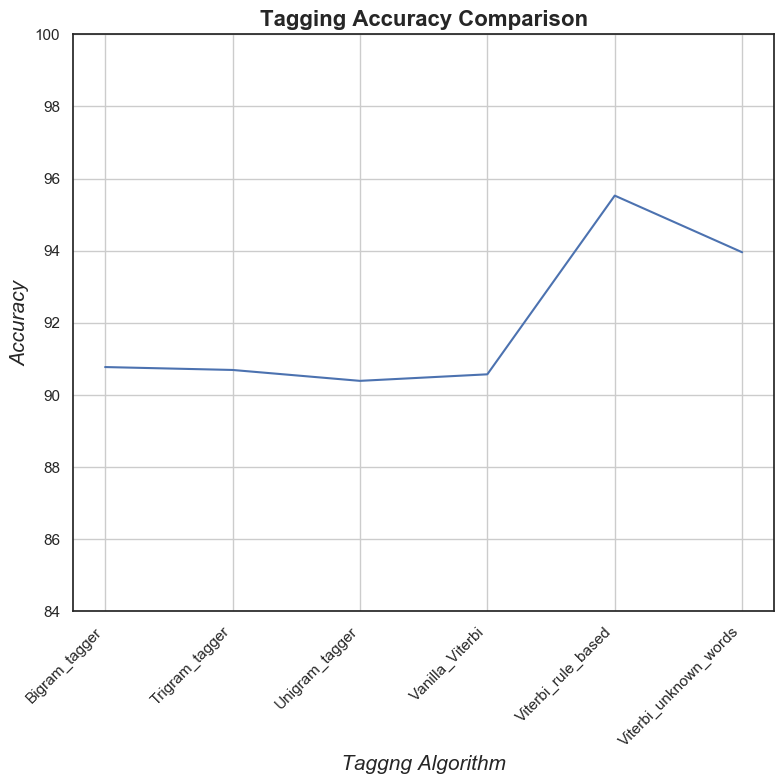

In [38]:
sns.set(style='white')
plt.figure(figsize=(8,8), dpi=100)
ax = sns.lineplot(data = accuracy_metrics_df)
ax.get_legend().remove()
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Tagging Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Taggng Algorithm', fontsize= 15, fontstyle='oblique')
plt.ylabel('Accuracy', fontsize= 15, fontstyle='oblique')
plt.ylim(84,100)
plt.grid(True)
plt.tight_layout()
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Lets read the test sentences given to check the how the vanilla and modified viterbi algorithms behave on this test data

In [39]:
file = open('Test_sentences.txt')

In [40]:
##Reading the file
test_sentence = file.read()
## Removing the last three lines as the file has new line characters as the last three lines
test_data = test_sentence.splitlines()[:-3]
file.close()
test_data

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [41]:
##Splitting the sentences to words
test_words = [word for sent in test_data for word in sent.split()]

In [42]:
# tagging the validation sentences
start = time.time()
tagged_seq_test = Vanilla_Viterbi(test_words)
end = time.time()
difference = end-start
tagged_seq_test

[('Android', 'PRT'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'PRT'),
 ('Android', 'PRT'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('on', 'ADP'),
 ('smartphones', 'PRT'),
 ('since', 'ADP'),
 ('2011', 'PRT'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'PRT'),
 ('Google', 'PRT'),
 ('and', 'CONJ'),
 ('Twitter', 'PRT'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRT'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'PRT'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'PRT'),
 ('firehose.', 'PRT'),
 ('Twitter', 'PRT'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRT'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET'),
 ('users',

In [43]:
# tagging the validation sentences
start = time.time()
tagged_seq_test_unk = Viterbi_unknown_words(test_words)
end = time.time()
difference = end-start
tagged_seq_test_unk

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'DET'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'DET'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'VERB'),
 ('firehose.', 'X'),
 ('Twitter', 'VERB'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET'),
 ('us

In [44]:
# tagging the validation sentences
start = time.time()
tagged_seq_test_rule = Viterbi_rule_based(test_words)
end = time.time()
difference = end-start
tagged_seq_test_rule

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

### Cases that were tagged incorrectly by Vanilla Viterbi Algorithm but were corrected after applying the modifications

- `Android` is correctly tagged as NOUN
- `Google` is correctly tagged as NOUN
- `Twitter` is correctly tagged as NOUN
- `Year 2011 ,2013 ,2015` are correctly tagged as NUM
